In [1]:
%load_ext autoreload
%autoreload 2

[INFO] 2025-03-26 02:03:02 - <fbpinns.constants.Constants object at 0x7f28406b5dd0>
run: test
domain: <class 'fbpinns.domains.RectangularDomainND'>
domain_init_kwargs: {'xmin': array([0., 0.]), 'xmax': array([1., 1.])}
problem: <class 'fbpinns.problems.HeatEquation1D'>
problem_init_kwargs: {'alpha': 1.0}
decomposition: <class 'fbpinns.decompositions.RectangularDecompositionND'>
decomposition_init_kwargs: {'subdomain_xs': [array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ]), array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])], 'subdomain_ws': [array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222]), array([0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222,
       0.32222222, 0.32222222, 0.32222222, 0.32222222, 0.32222222])], 'unnorm': (

[INFO] 2025-03-26 02:03:02 - Total number of trainable parameters:
[INFO] 2025-03-26 02:03:02 - 	network: 441,700
[INFO] 2025-03-26 02:03:02 - Total number of constraints: 1
[INFO] 2025-03-26 02:03:02 - Computing exact solution..
[INFO] 2025-03-26 02:03:02 - Computing done
[INFO] 2025-03-26 02:03:02 - Getting test data inputs..
[INFO] 2025-03-26 02:03:03 - [i: 0/20000] Updating active inputs..
[INFO] 2025-03-26 02:03:03 - [i: 0/20000] Average number of points/dimension in active subdomains: 20.86
[INFO] 2025-03-26 02:03:04 - [i: 0/20000] Updating active inputs done (1.38 s)
[INFO] 2025-03-26 02:03:04 - [i: 0/20000] Compiling update step..
[INFO] 2025-03-26 02:03:04 - x_batch
[INFO] 2025-03-26 02:03:04 - (1600, 2), float32, JVPTracer
[INFO] 2025-03-26 02:03:04 - x_take
[INFO] 2025-03-26 02:03:04 - (11152, 2), float32, JVPTracer
input: (2,)
(64,)
(64,)
(64,)
output: (1,)
[INFO] 2025-03-26 02:03:05 - x_batch
[INFO] 2025-03-26 02:03:05 - (1600, 2), float32, JVPTracer
[INFO] 2025-03-26 02:0

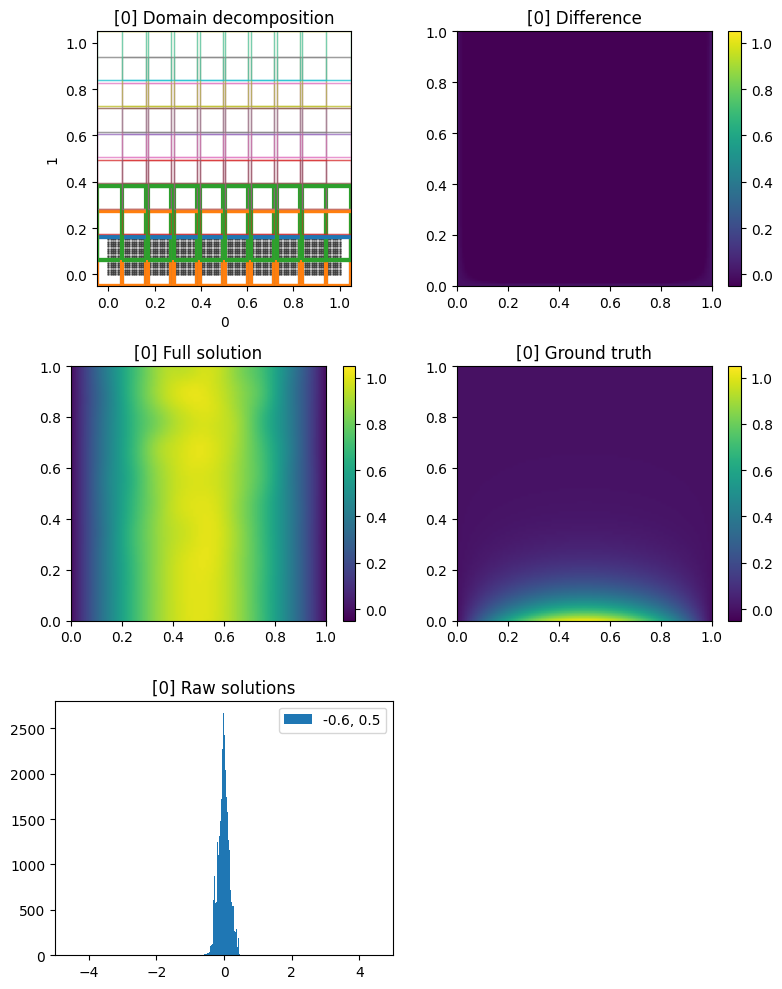

[INFO] 2025-03-26 02:03:11 - [i: 1000/20000] loss: 0.0862 rate: 143.7 elapsed: 0.00 hr test
[INFO] 2025-03-26 02:03:11 - [i: 1053/20000] Updating active inputs..
[INFO] 2025-03-26 02:03:11 - [i: 1053/20000] Average number of points/dimension in active subdomains: 27.10
[INFO] 2025-03-26 02:03:12 - [i: 1053/20000] Updating active inputs done (1.38 s)
[INFO] 2025-03-26 02:03:12 - [i: 1053/20000] Compiling update step..
[INFO] 2025-03-26 02:03:12 - x_batch
[INFO] 2025-03-26 02:03:12 - (2700, 2), float32, JVPTracer
[INFO] 2025-03-26 02:03:12 - x_take
[INFO] 2025-03-26 02:03:12 - (19584, 2), float32, JVPTracer
input: (2,)
(64,)
(64,)
(64,)
output: (1,)
[INFO] 2025-03-26 02:03:13 - x_batch
[INFO] 2025-03-26 02:03:13 - (2700, 2), float32, JVPTracer
[INFO] 2025-03-26 02:03:13 - x_take
[INFO] 2025-03-26 02:03:13 - (19584, 2), float32, JVPTracer
input: (2,)
(64,)
(64,)
(64,)
output: (1,)
[INFO] 2025-03-26 02:03:13 - [i: 1053/20000] Compiling done (0.97 s)
[INFO] 2025-03-26 02:03:20 - [i: 2000/20

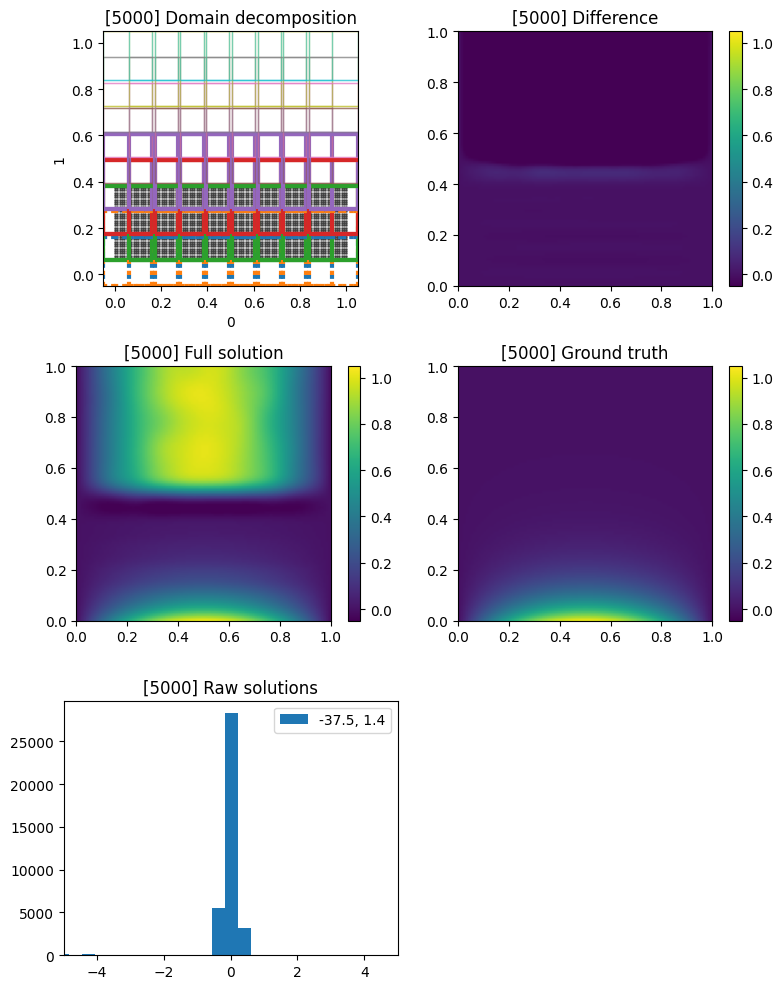

[INFO] 2025-03-26 02:03:50 - [i: 5264/20000] Updating active inputs..
[INFO] 2025-03-26 02:03:50 - [i: 5264/20000] Average number of points/dimension in active subdomains: 29.04
[INFO] 2025-03-26 02:03:50 - [i: 5264/20000] Updating active inputs done (0.16 s)
[INFO] 2025-03-26 02:03:50 - [i: 5264/20000] Compiling update step..
[INFO] 2025-03-26 02:03:50 - [i: 5264/20000] Compiling done (0.02 s)
[INFO] 2025-03-26 02:03:56 - [i: 6000/20000] loss: 0.0415 rate: 111.7 elapsed: 0.01 hr test
[INFO] 2025-03-26 02:04:05 - [i: 7000/20000] loss: 0.0284 rate: 122.7 elapsed: 0.02 hr test
[INFO] 2025-03-26 02:04:08 - [i: 7369/20000] Updating active inputs..
[INFO] 2025-03-26 02:04:08 - [i: 7369/20000] Average number of points/dimension in active subdomains: 29.04
[INFO] 2025-03-26 02:04:08 - [i: 7369/20000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 02:04:08 - [i: 7369/20000] Compiling update step..
[INFO] 2025-03-26 02:04:08 - [i: 7369/20000] Compiling done (0.02 s)
[INFO] 2025-03-26 02

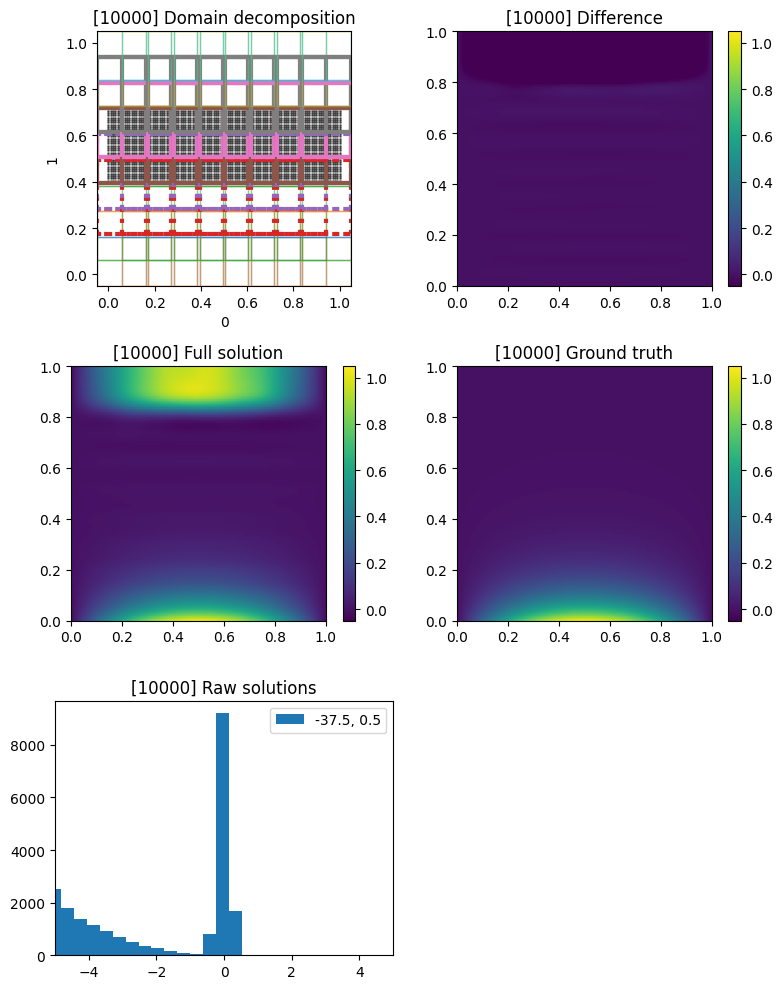

[INFO] 2025-03-26 02:04:39 - [i: 11000/20000] loss: 0.0466 rate: 119.9 elapsed: 0.03 hr test
[INFO] 2025-03-26 02:04:44 - [i: 11579/20000] Updating active inputs..
[INFO] 2025-03-26 02:04:44 - [i: 11579/20000] Average number of points/dimension in active subdomains: 29.04
[INFO] 2025-03-26 02:04:44 - [i: 11579/20000] Updating active inputs done (0.05 s)
[INFO] 2025-03-26 02:04:44 - [i: 11579/20000] Compiling update step..
[INFO] 2025-03-26 02:04:44 - [i: 11579/20000] Compiling done (0.02 s)
[INFO] 2025-03-26 02:04:48 - [i: 12000/20000] loss: 0.0976 rate: 118.2 elapsed: 0.03 hr test
[INFO] 2025-03-26 02:04:57 - [i: 13000/20000] loss: 0.0189 rate: 119.5 elapsed: 0.03 hr test
[INFO] 2025-03-26 02:05:02 - [i: 13685/20000] Updating active inputs..
[INFO] 2025-03-26 02:05:02 - [i: 13685/20000] Average number of points/dimension in active subdomains: 29.04
[INFO] 2025-03-26 02:05:03 - [i: 13685/20000] Updating active inputs done (0.12 s)
[INFO] 2025-03-26 02:05:03 - [i: 13685/20000] Compiling

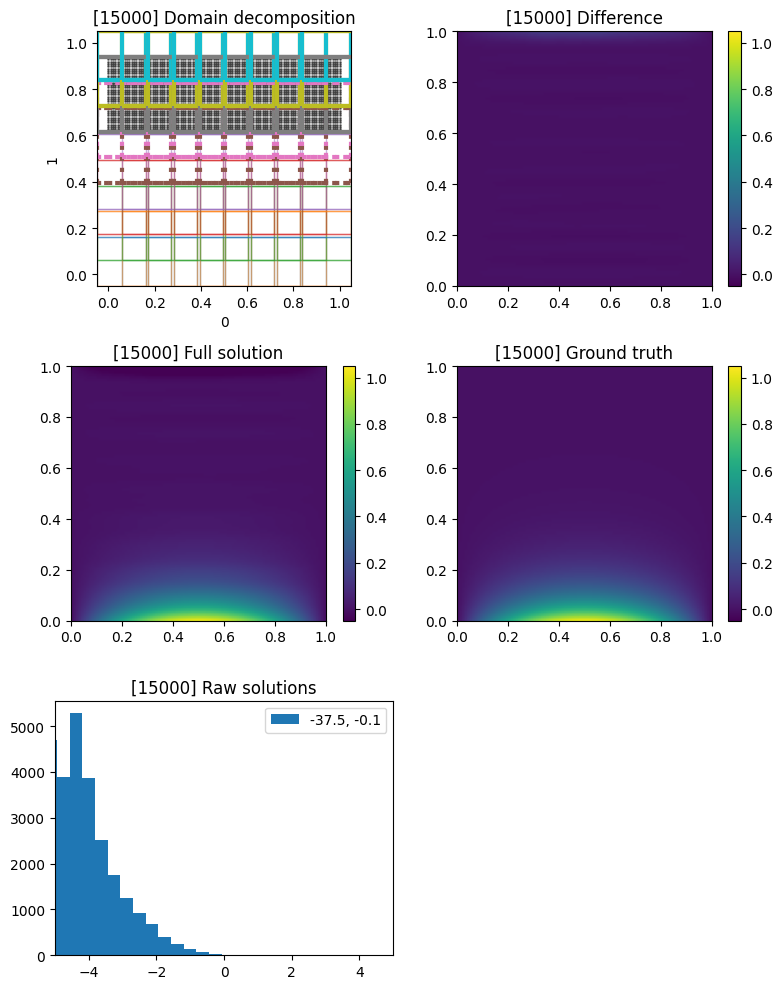

[INFO] 2025-03-26 02:05:21 - [i: 15790/20000] Updating active inputs..
[INFO] 2025-03-26 02:05:21 - [i: 15790/20000] Average number of points/dimension in active subdomains: 27.10
[INFO] 2025-03-26 02:05:21 - [i: 15790/20000] Updating active inputs done (0.10 s)
[INFO] 2025-03-26 02:05:21 - [i: 15790/20000] Compiling update step..
[INFO] 2025-03-26 02:05:21 - x_batch
[INFO] 2025-03-26 02:05:21 - (2700, 2), float32, JVPTracer
[INFO] 2025-03-26 02:05:21 - x_take
[INFO] 2025-03-26 02:05:21 - (19584, 2), float32, JVPTracer
input: (2,)
(64,)
(64,)
(64,)
output: (1,)
[INFO] 2025-03-26 02:05:21 - x_batch
[INFO] 2025-03-26 02:05:21 - (2700, 2), float32, JVPTracer
[INFO] 2025-03-26 02:05:21 - x_take
[INFO] 2025-03-26 02:05:21 - (19584, 2), float32, JVPTracer
input: (2,)
(64,)
(64,)
(64,)
output: (1,)
[INFO] 2025-03-26 02:05:22 - [i: 15790/20000] Compiling done (0.89 s)
[INFO] 2025-03-26 02:05:24 - [i: 16000/20000] loss: 0.1694 rate: 110.2 elapsed: 0.04 hr test
[INFO] 2025-03-26 02:05:31 - [i: 1

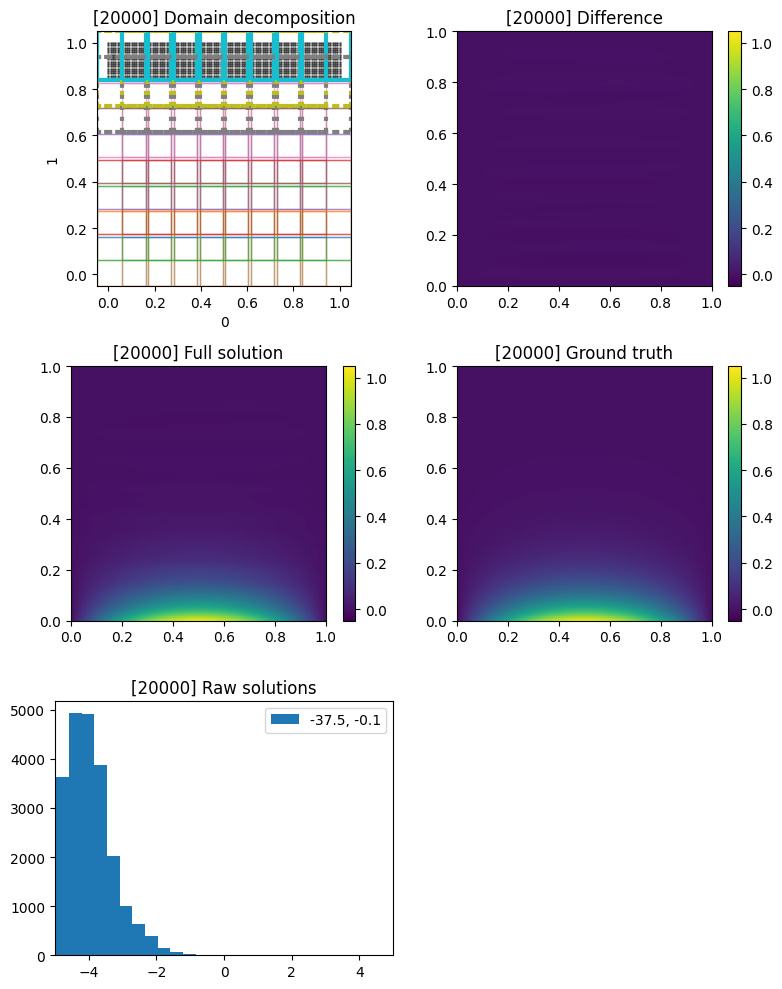

[INFO] 2025-03-26 02:05:46 - [i: 20000/20000] Training complete


{'static': {'domain': {'xd': 2,
   'xmin': Array([0., 0.], dtype=float32),
   'xmax': Array([1., 1.], dtype=float32)},
  'problem': {'dims': (1, 2), 'alpha': 1.0},
  'decomposition': {'m': np.int64(100),
   'xd': 2,
   'subdomain': {'params': [Array([[-0.16111112, -0.16111112],
            [-0.16111112, -0.05      ],
            [-0.16111112,  0.06111111],
            [-0.16111112,  0.17222223],
            [-0.16111112,  0.28333333],
            [-0.16111112,  0.39444444],
            [-0.16111112,  0.50555557],
            [-0.16111112,  0.6166667 ],
            [-0.16111112,  0.7277778 ],
            [-0.16111112,  0.8388889 ],
            [-0.05      , -0.16111112],
            [-0.05      , -0.05      ],
            [-0.05      ,  0.06111111],
            [-0.05      ,  0.17222223],
            [-0.05      ,  0.28333333],
            [-0.05      ,  0.39444444],
            [-0.05      ,  0.50555557],
            [-0.05      ,  0.6166667 ],
            [-0.05      ,  0.7277778 ],
 

In [ ]:
import numpy as np
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import HeatEquation1D  # our newly defined problem
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN, ChebyshevKAN
from fbpinns.schedulers import LineSchedulerRectangularND
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer

# Set the final time for the simulation
T = 1.0
subdomain_xs=[np.linspace(0,1,10), np.linspace(0,1,10)]

# Create a Constants object to hold all hyperparameters
c = Constants(
    # Define the problem domain (x and t)
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([0.0, 0.0]),  # x in [0, 1] and t in [0, T]
        xmax=np.array([1.0, T])
    ),
    # Set the problem to our heat equation
    problem=HeatEquation1D,
    problem_init_kwargs=dict(alpha=1.0),
    # Use a rectangular domain decomposition
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        # Split both x and t into 11 subdomains (you can adjust this as needed)
        subdomain_xs=subdomain_xs,
        subdomain_ws=get_subdomain_ws(subdomain_xs, 2.9),
        unnorm=(0, 1)
    ),
    # Use a fully-connected network; note the input layer size is 2 (x and t)
    network=FCN,
    network_init_kwargs=dict(layer_sizes=[2, 64, 64, 1]),
    scheduler = LineSchedulerRectangularND,
    scheduler_kwargs = dict(
        point=[0.], iaxis=0,
    ),
    # Number of training collocation points and testing points
    # ns=((200,),),
    # n_test=(500,),
    ns=((100,100),),
    n_test=(100,100),
    # Set training steps and optimizer parameters
    n_steps=20000,
    # optimiser_kwargs=dict(learning_rate=1e-3),
    clear_output=False,
)

# Create the trainer and start training
run = FBPINNTrainer(c)
run.train()